In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
from datautils import plot_dataset, create_dataset, sort_dataset

## Algorithm

In [3]:
def compute_median(dataset, axis="x"):
    """
    주어진 데이터포인트에 대해 median 값 반환
    """
    
    if axis == "x":
        axis = 1
    elif axis == "y":
        axis = 2
        
    median = np.median(dataset[:, axis])
    
    return median

In [4]:
def is_valid_triangle(p1, p2, p3):
    dist1 = np.sqrt(np.sum((p1[1:] - p2[1:])**2))
    dist2 = np.sqrt(np.sum((p2[1:] - p3[1:])**2))
    dist3 = np.sqrt(np.sum((p1[1:] - p3[1:])**2))
    
    if sum([dist1, dist2, dist3]) > 2*max([dist1, dist2, dist3]):
        return True
    else:
        return False

In [5]:
def compute_distance(p1, p2, p3):
    """
    주어진 2개 데이터포인트에 대해 거리 계산
    """
    
    distance = np.sqrt(np.sum((p1[1:] - p2[1:])**2)) + \
               np.sqrt(np.sum((p2[1:] - p3[1:])**2)) + \
               np.sqrt(np.sum((p1[1:] - p3[1:])**2))
    
    return distance

In [6]:
def get_median_points(sorted_dataset, median, d, axis="x"):
    """
    Median 근처의 데이터포인트(좌우 d 이하로 떨어진) 찾아서 반환
    """
    
    if axis == "x":
        axis = 1
    elif axis == "y":
        axis = 2
    
    filtered_dataset = sorted_dataset[
        (sorted_dataset[:, axis] >= median - d/2) & (sorted_dataset[:, axis] <= median + d/2)
    ]
    return filtered_dataset

In [10]:
def compute_median_smallest_triangle(median_datapoints, d, along_axis="y"):
    """
    Median 근처 데이터포인트들에서 smallest_triangle 계산
    """
    
    if along_axis == "x":
        along_axis = 1
    elif along_axis == "y":
        along_axis = 2
    
    N = median_datapoints.shape[0]
    min_distance = d
    smallest_triangle = None
    
    if N > 0:
        # 정렬 다시하지 말것
        # median_datapoints = sort_dataset(median_datapoints, axis="y")
    
        # y축 기준 제일 작은 포인트부터 루프
        for i in range(N):
            datapoint = median_datapoints[i]

            # 현재 데이터포인트 기준, y축으로 d 이하로 떨어진 포인트들만 걸러냄
            # filtered_median_datapoints = median_datapoints[
            #     (median_datapoints[:, along_axis] >= datapoint[along_axis]) & (median_datapoints[:, along_axis] <= datapoint[along_axis] + d)
            # ]
            filtered_median_datapoints = []
            for j in range(i + 1, N):
                point = median_datapoints[j]
                
                # 현재 데이터포인트부터 y축 값이 큰 값의 데이터포인트를 차례대로 얻어오고, 그 값이 범위내에 있는지 검사
                if point[along_axis] >= datapoint[along_axis] and point[along_axis] <= datapoint[along_axis] + d/2:
                    filtered_median_datapoints.append(point)
                # 범위내에 없으면 더 검사할 필요 없이 break
                else:
                    break
                    
            if len(filtered_median_datapoints) > 0:
                # 편의를 위해 numpy array로 바꿔주는 코드
                filtered_median_datapoints = np.stack(filtered_median_datapoints, axis=0)

                # 걸러진 포인트개수
                M = filtered_median_datapoints.shape[0]

                # closest pair 계산
                for j in range(M):
                    for k in range(j + 1, M):
                        point2 = filtered_median_datapoints[j]
                        point3 = filtered_median_datapoints[k]

                        if not is_valid_triangle(datapoint, point2, point3):
                            continue
                            
                        dist = compute_distance(datapoint, point2, point3)

                        if dist < min_distance and dist > 0:
                            min_distance = dist
                            smallest_triangle = (datapoint, point2, point3)
                
    return smallest_triangle

In [13]:
def compute_smallest_triangle(x_sorted_dataset, y_sorted_dataset):
    """
    Closest pair 계산 알고리즘
    """
    
    N = x_sorted_dataset.shape[0]
    if N < 3:                  # 해당 영역에 데이터포인트가 하나밖에 없는 경우
        return None
    elif N == 3:                # 해당 영역에 데이터포인트가 두개밖에 없는 경우
        p1 = x_sorted_dataset[0]
        p2 = x_sorted_dataset[1]
        p3 = x_sorted_dataset[2]
        
        if is_valid_triangle(p1, p2, p3):
            return (p1, p2, p3)
        else:
            return None
    else:                       # 해당 영역에 데이터포인트가 2개 이상인 경우
        # median 값 계산
        x_median = compute_median(x_sorted_dataset, axis="x")
        
        # median 값 기준으로 좌우로 데이터셋을 나눔
        dataset_left_x = x_sorted_dataset[x_sorted_dataset[:, 1] <= x_median]
        dataset_right_x = x_sorted_dataset[x_sorted_dataset[:, 1] > x_median]
        
        dataset_left_y = y_sorted_dataset[y_sorted_dataset[:, 1] <= x_median]
        dataset_right_y = y_sorted_dataset[y_sorted_dataset[:, 1] > x_median]
        
        # 좌우 영역에서 각각 closest pair 계산
        pair_left = compute_smallest_triangle(dataset_left_x, dataset_left_y)
        pair_right = compute_smallest_triangle(dataset_right_x, dataset_right_y)

        
        if pair_left is None:  # 좌측 영역에 데이터포인트가 2개 이하밖에 없었을 경우
            min_distance_left = np.inf
        else:
            min_distance_left = compute_distance(pair_left[0], pair_left[1], pair_left[2])
            
        if pair_right is None: # 우측 영역에 데이터포인트가 2개 이하밖에 없었을 경우
            min_distance_right = np.inf
        else:
            min_distance_right = compute_distance(pair_right[0], pair_right[1], pair_right[2])
        
        # 좌우측의 smallest triangle를 바탕으로 전체(?) closest pair 계산
        if min_distance_left == min_distance_right == np.inf:
            min_distance = np.inf
            smallest_triangle = None
        elif min_distance_left < min_distance_right:
            min_distance = min_distance_left
            smallest_triangle = pair_left
        elif min_distance_left > min_distance_right:
            min_distance = min_distance_right
            smallest_triangle = pair_right
        
        # median 근처의 데이터포인트만 얻어옴
        median_points = get_median_points(y_sorted_dataset, x_median, min_distance, axis="x")
        
        # median 근처 포인트들 중에서 closest pair 계산
        median_smallest_triangle = compute_median_smallest_triangle(median_points, min_distance, along_axis="y")
        
        # smallest triangle가 median 근처에 있었을 경우, global smallest triangle 업데이트
        if median_smallest_triangle is not None:
            smallest_triangle = median_smallest_triangle
        
        return smallest_triangle

In [14]:
dataset = create_dataset(N=100)
x_sorted_dataset = sort_dataset(dataset, axis="x")
y_sorted_dataset = sort_dataset(dataset, axis="y")

pair = compute_smallest_triangle(x_sorted_dataset, y_sorted_dataset)
print(pair, compute_distance(*pair))

(array([41.        ,  0.58898365,  0.85779393]), array([62.        ,  0.58934881,  0.80521265]), array([22.        ,  0.59793358,  0.83908501])) 0.10826532308425724


## 테스트용 나이브 smallest triangle 코드

In [15]:
def check(dataset):
    N = dataset.shape[0]
    
    min_dist = np.inf
    closest_pair = None
    
    for i in range(N):
        for j in range(i + 1, N):
            for k in range(j + 1, N):
                p1 = dataset[i]
                p2 = dataset[j]
                p3 = dataset[k]

                dist = compute_distance(p1, p2, p3)
                
                if dist < min_dist:
                    min_dist = dist
                    closest_pair = (p1, p2, p3)
                
    return closest_pair

In [16]:
pair_check = check(dataset)
print(pair_check, compute_distance(*pair_check))

(array([22.        ,  0.59793358,  0.83908501]), array([41.        ,  0.58898365,  0.85779393]), array([62.        ,  0.58934881,  0.80521265])) 0.10826532308425725


## Test

In [21]:
def unit_test(n_iter):
    for i in range(n_iter):
        test_dataset = create_dataset(N=100)
        x_sorted_test_dataset = sort_dataset(test_dataset, axis="x")
        y_sorted_test_dataset = sort_dataset(test_dataset, axis="y")

        pair1 = compute_smallest_triangle(x_sorted_test_dataset, y_sorted_test_dataset)
        pair2 = check(test_dataset)
        
        dist1 = compute_distance(*pair1)
        dist2 = compute_distance(*pair2)
        
        assert abs(dist1 - dist2) < 1e-8, f"테스트실패! pair1: {pair1}, pair2: {pair2}, distance: {dist1}, {dist2}"
        
    print("테스트성공")

In [23]:
unit_test(50)

테스트성공


## 실행시간 그래프

In [24]:
def test_with_n(N):
    dataset = create_dataset(N)
    x_sorted_test_dataset = sort_dataset(dataset, axis="x")
    y_sorted_test_dataset = sort_dataset(dataset, axis="y")
    
    start_time = time.time()
    smallest_triangle = compute_smallest_triangle(x_sorted_test_dataset, y_sorted_test_dataset)
    duration = time.time() - start_time
    
    return duration

데이터포인트 200개부터 10000개까지 200개씩 늘려가면서 실험.
똑같은 개수의 데이터포인트마다 다섯번 돌려서 평균냄

In [25]:
durations = []

for n in range(200, 10000, 200):
    duration = 0.0
    for i in range(5):
        duration += test_with_n(n)
        
    durations.append(duration/5)

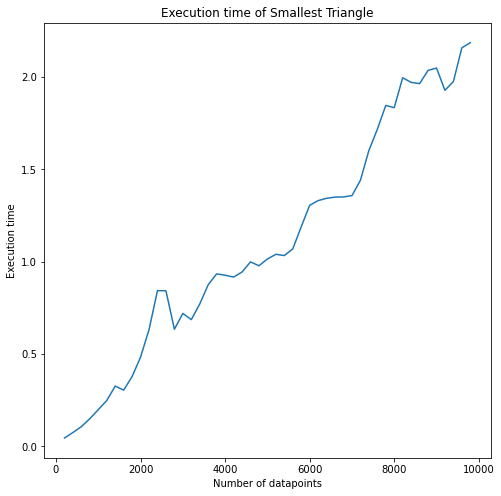

In [26]:
plt.figure(figsize=(8, 8))
plt.plot(list(range(200, 10000, 200)), durations)
plt.xlabel("Number of datapoints")
plt.ylabel("Execution time")
plt.title("Execution time of Smallest Triangle")
plt.show()